### Multi-Class Classification Problem for demonstrating the effect of Greedy Layerwise Pretraining


- The problem will be <b> configured with two input variables </b> (to represent the x and y coordinates of the points) and a standard deviation of 2.0 for points within each group. We will use the same random state (seed for the pseudorandom number generator) to ensure that we always get the same data points.





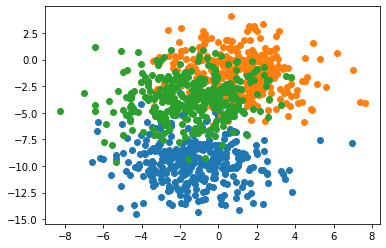

In [47]:
# scatter plot of blobs dataset
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from numpy import where

# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)

# scatter plot for each class value
for class_value in range(3):
 # select indices of points with the class label
 row_ix = where(y == class_value)
 # scatter plot for points with a different color
 pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show plot
pyplot.show()

#### Supervised Greedy Layer-Wise Pretraining

Use greedy layer-wise supervised learning to build up a deep Multilayer Perceptron (MLP) model for the blobs supervised learning multi-class classification problem.

Pretraining is not required to address this simple predictive modeling problem. Instead, this is a demonstration of how to perform supervised greedy layer-wise pretraining that can be used as a template for larger and more challenging supervised learning problems.

As a first step, we can develop a function to create 1,000 samples from the problem and split them evenly into train and test datasets. The prepare_data() function below implements this and returns the train and test sets in terms of the input and output components.

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import to_categorical


# prepare the dataset
def prepare_data():
    # generate 2d classification dataset
    X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)
 
    # one hot encode output variable
    y = to_categorical(y)
    
     # split into train and test
    n_train = 500
    trainX, testX = X[:n_train, :], X[n_train:, :]
    trainy, testy = y[:n_train], y[n_train:]
    return trainX, testX, trainy, testy

trainX, testX, trainy, testy = prepare_data()

In [12]:
# define model
model = Sequential()
model.add(Dense(10, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(3, activation='softmax'))

Metal device set to: Apple M1 Pro


2023-07-11 11:08:43.795304: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-11 11:08:43.795395: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 10)                30        
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 10)                110       
                                                                 
 dense_6 (Dense)             (None, 10)                110       
                                                                 
 dense_7 (Dense)             (None, 10)                110       
                                                                 
 dense_8 (Dense)             (None, 10)                110       
                                                                 
 dense_9 (Dense)             (None, 10)               

In [13]:
# compile model
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [14]:
# fit model
model.fit(trainX, trainy, epochs=100, verbose=0)

2023-07-11 11:09:08.416979: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-07-11 11:09:08.575232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [15]:
# define and fit the base model
def get_base_model(trainX, trainy):
 # define model
 model = Sequential()
 model.add(Dense(10, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
 model.add(Dense(3, activation='softmax'))
 # compile model
 opt = SGD(lr=0.01, momentum=0.9)
 model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
 # fit model
 model.fit(trainX, trainy, epochs=100, verbose=0)
 return model

In [16]:
# get the base model
model = get_base_model(trainX, trainy)

2023-07-11 11:09:31.984695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [17]:
# evaluate a fit model
def evaluate_model(model, trainX, testX, trainy, testy):
	_, train_acc = model.evaluate(trainX, trainy, verbose=0)
	_, test_acc = model.evaluate(testX, testy, verbose=0)
	return train_acc, test_acc

In [18]:
# evaluate the base model
scores = dict()
train_acc, test_acc = evaluate_model(model, trainX, testX, trainy, testy)
print('> layers=%d, train=%.3f, test=%.3f' % (len(model.layers), train_acc, test_acc))

2023-07-11 11:09:54.888481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


> layers=2, train=0.816, test=0.826


In [19]:
# remember the current output layer
output_layer = model.layers[-1]

In [20]:
# remove the output layer
model.pop()

In [21]:
# mark all remaining layers as non-trainable
for layer in model.layers:
	layer.trainable = False

In [22]:
# add a new hidden layer
model.add(Dense(10, activation='relu', kernel_initializer='he_uniform'))

In [23]:
# re-add the output layer
model.add(output_layer)
# fit model
model.fit(trainX, trainy, epochs=100, verbose=0)

In [24]:
# add one new layer and re-train only the new layer
def add_layer(model, trainX, trainy):
	# remember the current output layer
	output_layer = model.layers[-1]
	# remove the output layer
	model.pop()
	# mark all remaining layers as non-trainable
	for layer in model.layers:
		layer.trainable = False
	# add a new hidden layer
	model.add(Dense(10, activation='relu', kernel_initializer='he_uniform'))
	# re-add the output layer
	model.add(output_layer)
	# fit model
	model.fit(trainX, trainy, epochs=100, verbose=0)

In [25]:
# add layers and evaluate the updated model
n_layers = 10
for i in range(n_layers):
	# add layer
	add_layer(model, trainX, trainy)
	# evaluate model
	train_acc, test_acc = evaluate_model(model, trainX, testX, trainy, testy)
	print('> layers=%d, train=%.3f, test=%.3f' % (len(model.layers), train_acc, test_acc))
	# store scores for plotting
	scores[len(model.layers)] = (train_acc, test_acc)

> layers=4, train=0.818, test=0.826
> layers=5, train=0.822, test=0.820
> layers=6, train=0.822, test=0.820
> layers=7, train=0.828, test=0.818
> layers=8, train=0.828, test=0.820
> layers=9, train=0.828, test=0.810
> layers=10, train=0.826, test=0.820
> layers=11, train=0.834, test=0.818
> layers=12, train=0.832, test=0.820
> layers=13, train=0.836, test=0.820


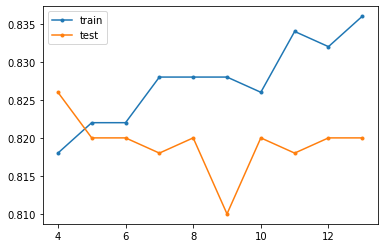

In [26]:
# plot number of added layers vs accuracy
pyplot.plot(list(scores.keys()), [scores[k][0] for k in scores.keys()], label='train', marker='.')
pyplot.plot(list(scores.keys()), [scores[k][1] for k in scores.keys()], label='test', marker='.')
pyplot.legend()
pyplot.show()